In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:

!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 


Cloning into 'mmsegmentation'...
remote: Enumerating objects: 14566, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 14566 (delta 26), reused 41 (delta 7), pack-reused 14413
Receiving objects: 100% (14566/14566), 18.26 MiB | 15.69 MiB/s, done.
Resolving deltas: 100% (10325/10325), done.


In [3]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

/opt/conda/envs/univer/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/envs/univer/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c104impl8GPUTrace13gpuTraceStateE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


1.12.0+cu102 True
0.30.0


## Run Inference with MMSeg trained weight

In [4]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints

mkdir: cannot create directory ‘checkpoints’: File exists
--2023-04-01 21:54:08--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.246.2.178, 47.246.2.214, 47.246.2.173, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|47.246.2.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.6’

pspnet_r50-d8_512x1 100%[===================>] 187.12M  6.95MB/s    in 23s     

2023-04-01 21:54:31 (8.26 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth.6’ saved [196205945/196205945]



In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

In [6]:
config_file = 'mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py'
checkpoint_file = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

In [7]:
# build the model from a config file and a checkpoint file
model = init_segmentor(config_file, checkpoint_file, device='cuda:0')

/root/other/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


In [8]:
# test a single image
img = 'mmsegmentation/demo/demo.png'
result = inference_segmentor(model, img)

/root/other/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


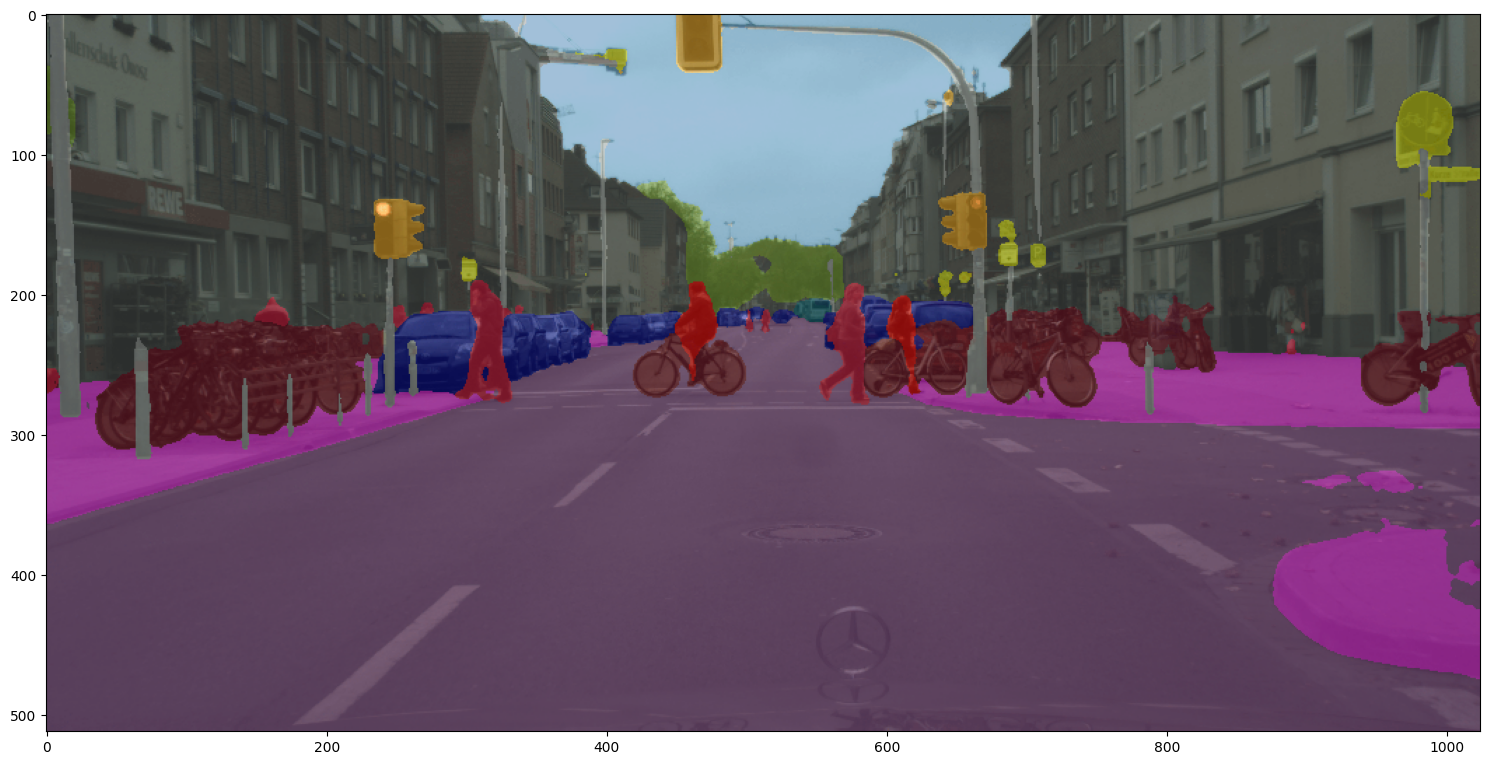

In [9]:
# show the results
show_result_pyplot(model, img, result, get_palette('cityscapes'))

In [10]:
from roboflow import Roboflow
rf = Roboflow(api_key="GyR74TdmCjPJ8Mp7PbKc")
project = rf.workspace("dmitry-karanov-xnath").project("oil-spots-segmentation")
dataset = project.version(7).download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Oil-Spots-Segmentation-7 in png-mask-semantic:


In [11]:
import os

len(os.listdir('Oil-Spots-Segmentation-7/train'))

1799

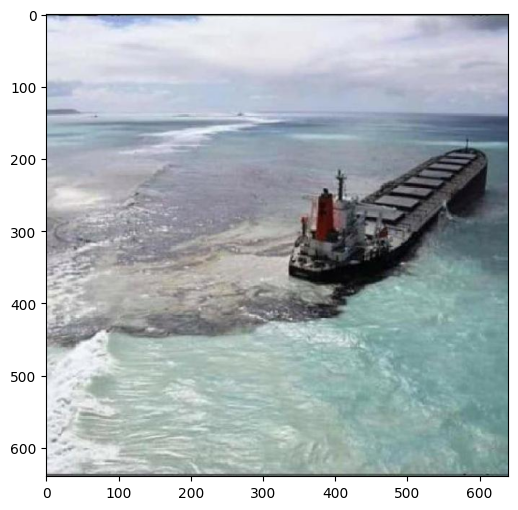

In [12]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('./Oil-Spots-Segmentation-7/test/13_jpg.rf.71637a15064c67d697a6f0751aff5708.jpg')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [13]:
!mkdir dataset 
!mkdir dataset/train 
!mkdir dataset/train/images 
!mkdir dataset/train/labels 
!mkdir dataset/test 
!mkdir dataset/test/images
!mkdir dataset/test/labels
!mkdir dataset/val
!mkdir dataset/val/images
!mkdir dataset/val/labels


In [14]:
import glob


In [15]:
for x in glob.glob('Oil-Spots-Segmentation-7/train/*'):
    if x.endswith('.jpg'):
        name_file = x.split('/')[-1]
        mask_name = name_file[:-4] + '.png'
        mask_path = x[:-4] + '_mask.png'
        os.rename(x, f"./dataset/train/images/{name_file}")
        os.rename(mask_path, f"./dataset/train/labels/{mask_name}")

In [16]:
for x in glob.glob('Oil-Spots-Segmentation-7/valid/*'):
    if x.endswith('.jpg'):
        name_file = x.split('/')[-1]
        mask_name = name_file[:-4] + '.png'
        mask_path = x[:-4] + '_mask.png'
        os.rename(x, f"./dataset/val/images/{name_file}")
        os.rename(mask_path, f"./dataset/val/labels/{mask_name}")

In [17]:
for x in glob.glob('Oil-Spots-Segmentation-7/test/*'):
    if x.endswith('.jpg'):
        name_file = x.split('/')[-1]
        mask_name = name_file[:-4] + '.png'
        mask_path = x[:-4] + '_mask.png'
        os.rename(x, f"./dataset/test/images/{name_file}")
        os.rename(mask_path, f"./dataset/test/labels/{mask_name}")

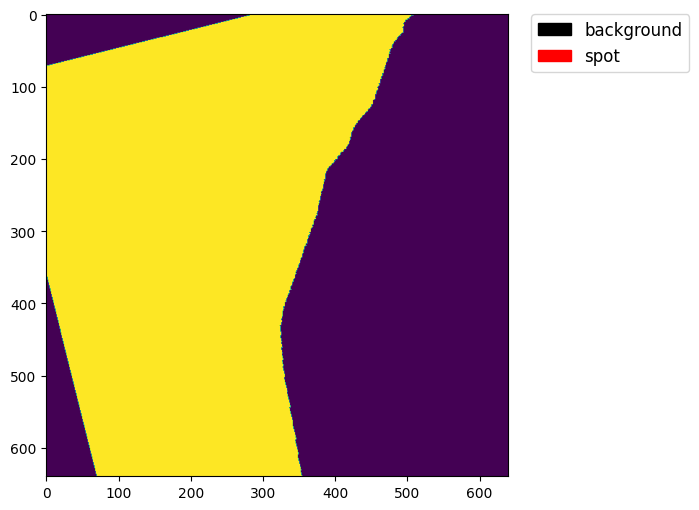

In [18]:
import cv2
import numpy as np
import matplotlib.patches as mpatches
from PIL import Image


classes = ( 'background','spot')
palette = [[0, 0, 0],[255, 0, 0]]

img = 'dataset/train/labels/104_jpg.rf.22f1569513a31ee351f792bb5924dca6.png'
seg_img = Image.open(img).convert('L')
seg_img.putpalette(np.array(palette, dtype=np.uint8))
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(seg_img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [19]:
for img in glob.glob('dataset/train/labels/*'):
    seg_img = Image.open(img).convert('L')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(img)

In [20]:
for img in glob.glob('dataset/valid/labels/*'):
    seg_img = Image.open(img).convert('L')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(img)

In [21]:
for img in glob.glob('dataset/test/labels/*'):
    seg_img = Image.open(img).convert('L')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(img)

In [22]:
# split train/val set randomly
split_dir = 'splits'
data_root = 'dataset'
tr = 'train'
val = 'val'
test = 'test'
img_dir = 'images'
ann_dir = 'labels'
mmcv.mkdir_or_exist(os.path.join(data_root, split_dir))
filename_list_train = [os.path.splitext(filename)[0] for filename in mmcv.scandir(
    os.path.join(data_root, tr, ann_dir), suffix='.png')]
with open(os.path.join(data_root, split_dir, 'train.txt'), 'w') as f:
  train_length = int(len(filename_list_train))
  f.writelines(line + '\n' for line in filename_list_train[:train_length])


filename_list_val = [os.path.splitext(filename)[0] for filename in mmcv.scandir(
    os.path.join(data_root, val, ann_dir), suffix='.png')]
with open(os.path.join(data_root, split_dir, 'val.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list_val)

filename_list_test = [os.path.splitext(filename)[0] for filename in mmcv.scandir(
    os.path.join(data_root, test, ann_dir), suffix='.png')]
with open(os.path.join(data_root, split_dir, 'test.txt'), 'w') as f:
  f.writelines(line + '\n' for line in filename_list_test)

In [23]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class SpotDataset(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.png',  **kwargs)

    

In [24]:
from mmcv import Config
cfg = Config.fromfile('mmsegmentation/configs/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes.py')

In [25]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device


# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2
# Modify dataset type and path
cfg.dataset_type = 'SpotDataset'
cfg.data_root = 'dataset'

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=1

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = os.path.join(cfg.data_root, 'train')
cfg.data.train.img_dir = 'images'
cfg.data.train.ann_dir = 'labels'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'dataset/splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = os.path.join(cfg.data_root, 'val')
cfg.data.val.img_dir = 'images'
cfg.data.val.ann_dir = 'labels'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'dataset/splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = os.path.join(cfg.data_root, 'test')
cfg.data.test.img_dir = 'images'
cfg.data.test.ann_dir = 'labels'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'dataset/splits/test.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 100000
cfg.log_config.interval = 10
cfg.evaluation.interval = 1000
cfg.checkpoint_config.interval = 5000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='open-mmlab://resnet50_v1c',
    backbone=dict(
        type='ResNetV1c',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True),
    decode_head=dict(
        type='PSPHead',
        in_channels=2048,
        in_index=3,
        channels=512,
        pool_scales=(1, 2, 3, 6),
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    auxiliary_head=dict(
        type='FCNHead',
        in_channels=1024,
        in_index=2,
        channels=256,
        num_convs=1,
        concat_input=F

### Train and Evaluation

In [26]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

print(datasets[0].CLASSES)

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES


'''
# Create work_dir
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())
'''

2023-04-01 21:55:16,451 - mmseg - INFO - Loaded 899 images
For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold


('background', 'spot')


'\n# Create work_dir\nmmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))\ntrain_segmentor(model, datasets, cfg, distributed=False, validate=True, \n                meta=dict())\n'

In [27]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=7BDQHX5DN3R8CP1MEPIT
%env CLEARML_API_SECRET_KEY=eocQd8zVW3WA32TgYZSRpCH6Nl60FwjRMycYB2GVs0opq7XLVJ

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=7BDQHX5DN3R8CP1MEPIT
env: CLEARML_API_SECRET_KEY=eocQd8zVW3WA32TgYZSRpCH6Nl60FwjRMycYB2GVs0opq7XLVJ


In [28]:
from clearml import Task

task = Task.init(project_name="Oil spill segmentation", task_name="Train pspnet segmentator (exp5)")


ClearML Task: created new task id=759d13b757a2405fb34413c5a195d702
2023-04-01 21:55:32,405 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/1efe18d65d9e45a1ba1d8df869e5e62e/experiments/759d13b757a2405fb34413c5a195d702/output/log
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [ ]:
mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2023-04-01 21:55:42,485 - mmseg - INFO - Loaded 58 images
2023-04-01 21:55:42,487 - mmseg - INFO - load checkpoint from local path: checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth


2023-04-01 21:55:43,324 - clearml.model - INFO - Selected model id: 9c929446c3884f298a27482822814d2e


2023-04-01 21:55:47,035 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
2023-04-01 21:55:47,040 - mmseg - INFO - Start running, host: root@deploy-5d5bff9947-8zx65, work_dir: /root/other/work_dirs/tutorial
2023-04-01 21:55:47,042 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VE

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 43.7 task/s, elapsed: 1s, ETA:     0s

2023-04-01 22:00:03,438 - mmseg - INFO - per class results:
2023-04-01 22:00:03,440 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 55.06 | 66.79 |
|    spot    | 36.61 | 59.64 |
+------------+-------+-------+
2023-04-01 22:00:03,441 - mmseg - INFO - Summary:
2023-04-01 22:00:03,442 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 64.32 | 45.83 | 63.22 |
+-------+-------+-------+
2023-04-01 22:00:03,443 - mmseg - INFO - Iter(val) [58]	aAcc: 0.6432, mIoU: 0.4583, mAcc: 0.6322, IoU.background: 0.5506, IoU.spot: 0.3661, Acc.background: 0.6679, Acc.spot: 0.5964
2023-04-01 22:00:07,963 - mmseg - INFO - Iter [1010/100000]	lr: 9.910e-03, eta: 7:05:58, time: 0.586, data_time: 0.349, memory: 3771, decode.loss_ce: 0.1854, decode.acc_seg: 89.8722, aux.loss_ce: 0.0801, aux.acc_seg: 88.9894, loss: 0.2655
2023-04-01 22:00:10,356 - mmseg - INFO - Iter [1020/100000]	lr: 9.909e

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 58/58, 46.9 task/s, elapsed: 1s, ETA:     0s

2023-04-01 22:04:26,745 - mmseg - INFO - per class results:
2023-04-01 22:04:26,746 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 57.67 | 65.45 |
|    spot    |  45.0 | 74.46 |
+------------+-------+-------+
2023-04-01 22:04:26,747 - mmseg - INFO - Summary:
2023-04-01 22:04:26,748 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 68.56 | 51.34 | 69.95 |
+-------+-------+-------+
2023-04-01 22:04:26,749 - mmseg - INFO - Iter(val) [58]	aAcc: 0.6856, mIoU: 0.5134, mAcc: 0.6995, IoU.background: 0.5767, IoU.spot: 0.4500, Acc.background: 0.6545, Acc.spot: 0.7446
2023-04-01 22:04:29,202 - mmseg - INFO - Iter [2010/100000]	lr: 9.821e-03, eta: 7:04:08, time: 0.370, data_time: 0.130, memory: 3771, decode.loss_ce: 0.1591, decode.acc_seg: 91.7139, aux.loss_ce: 0.0725, aux.acc_seg: 90.7510, loss: 0.2317
2023-04-01 22:04:33,717 - mmseg - INFO - Iter [2020/100000]	lr: 9.820e

/root/other/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning:

show==False and out_file is not specified, only result image will be returned



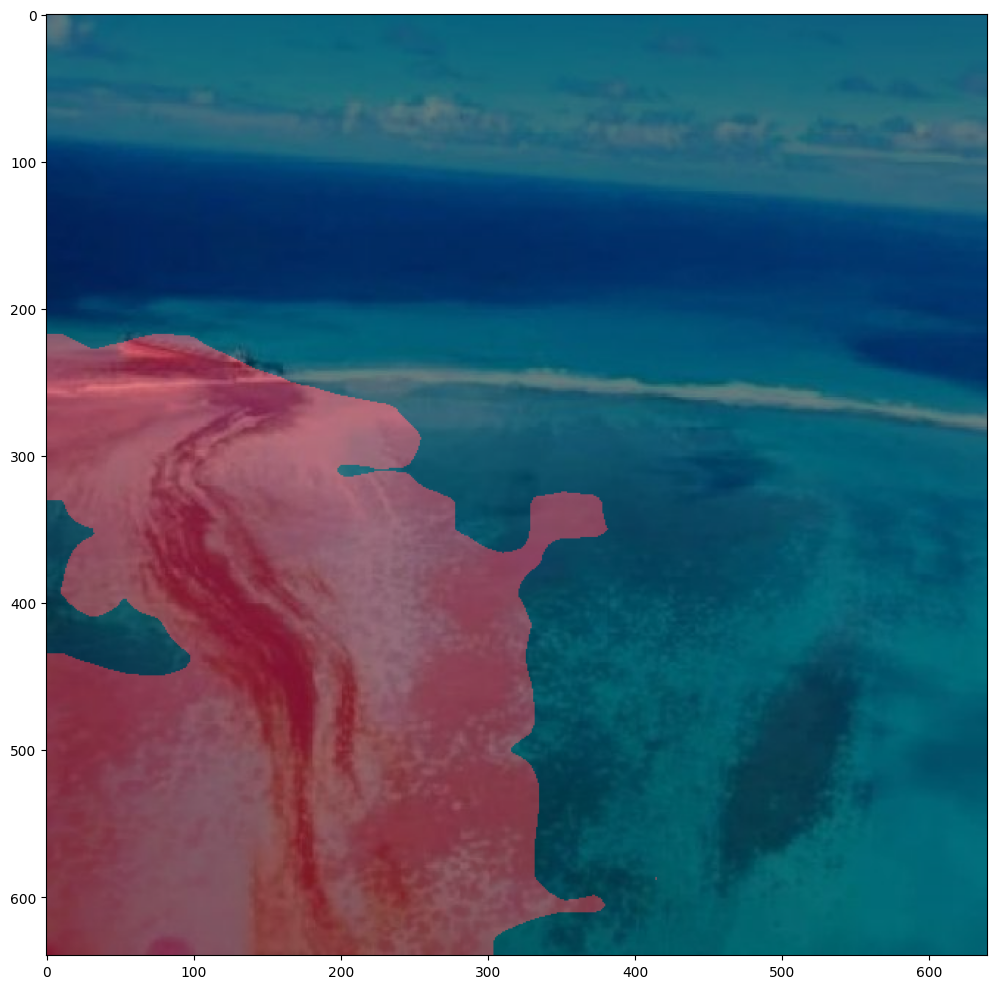

In [36]:
img = mmcv.imread('dataset/test/images/2_jpg.rf.2b08ac4536828a76bd15debc2b513e4e.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)

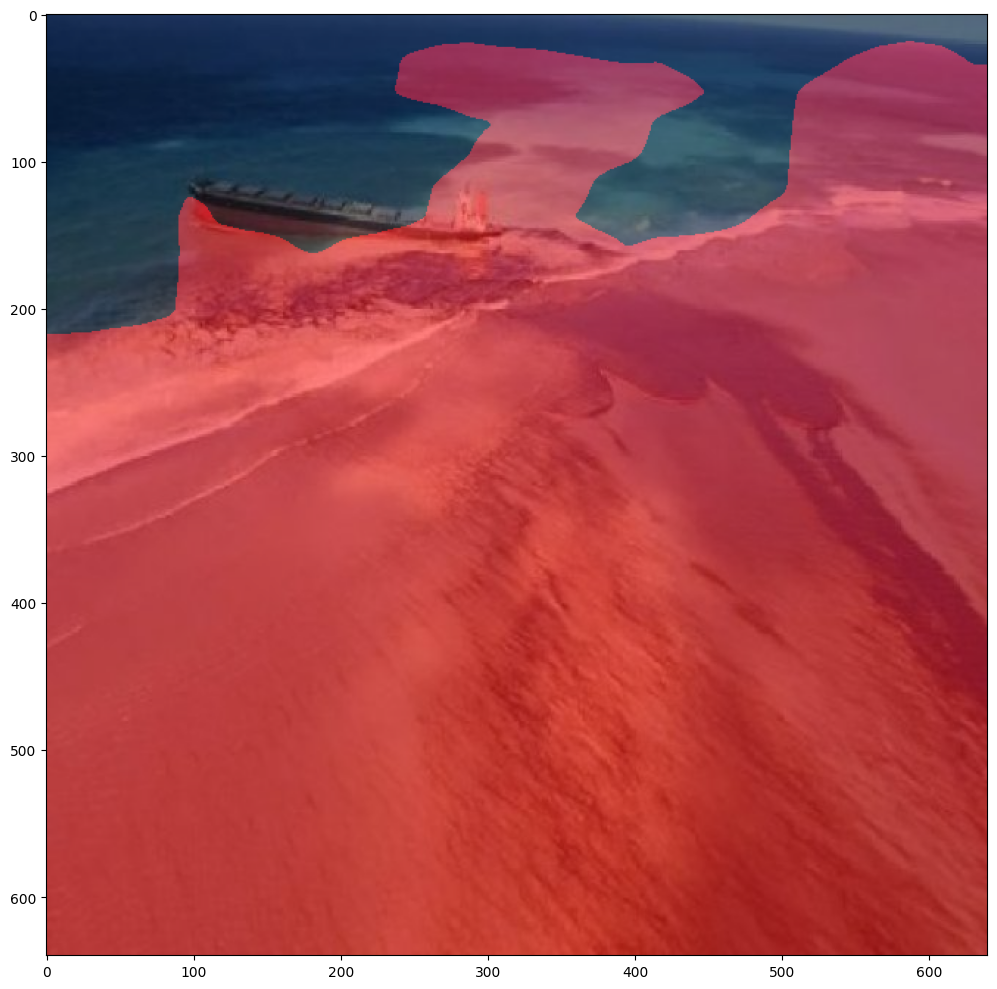

In [37]:
img = mmcv.imread('dataset/test/images/11_jpg.rf.6c5329ecc643f0fe7fd680a17c5d09a7.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)

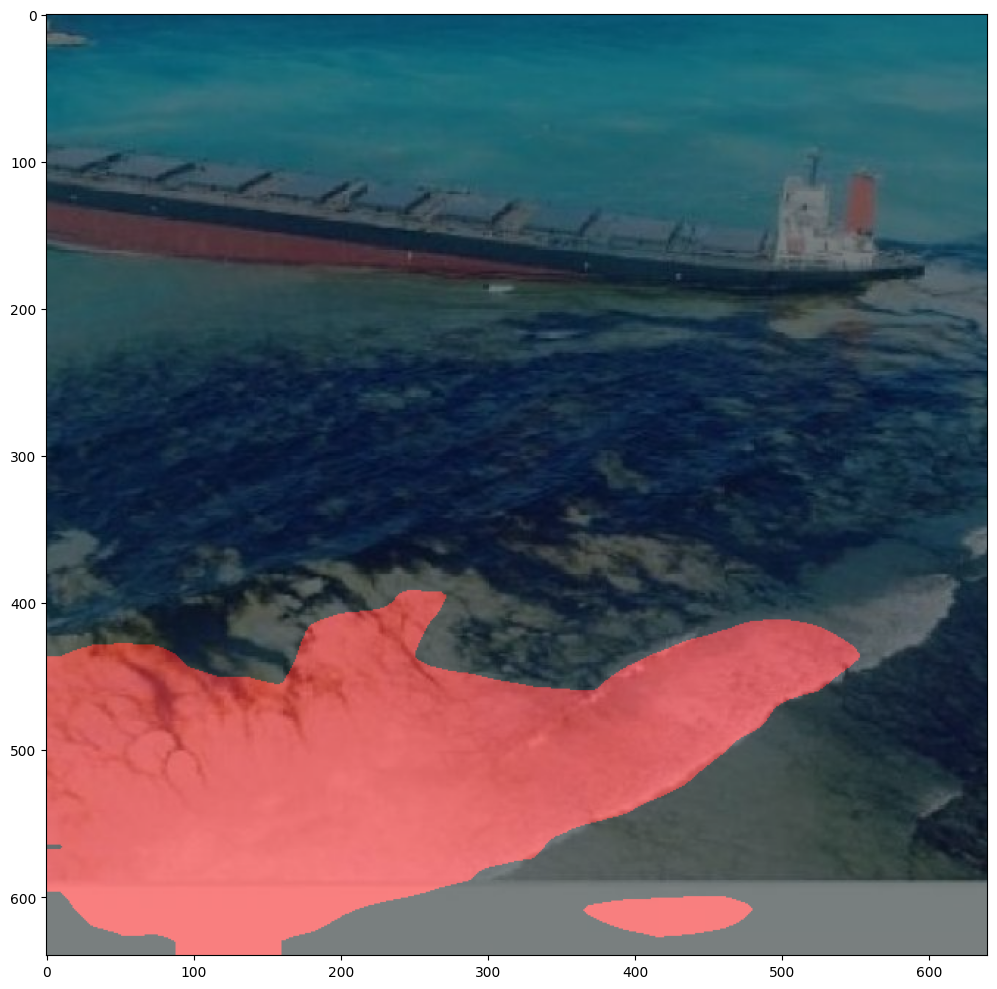

In [38]:
img = mmcv.imread('dataset/test/images/55_jpg.rf.505a037d9e377a75bd55c22c6d0ee93d.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)

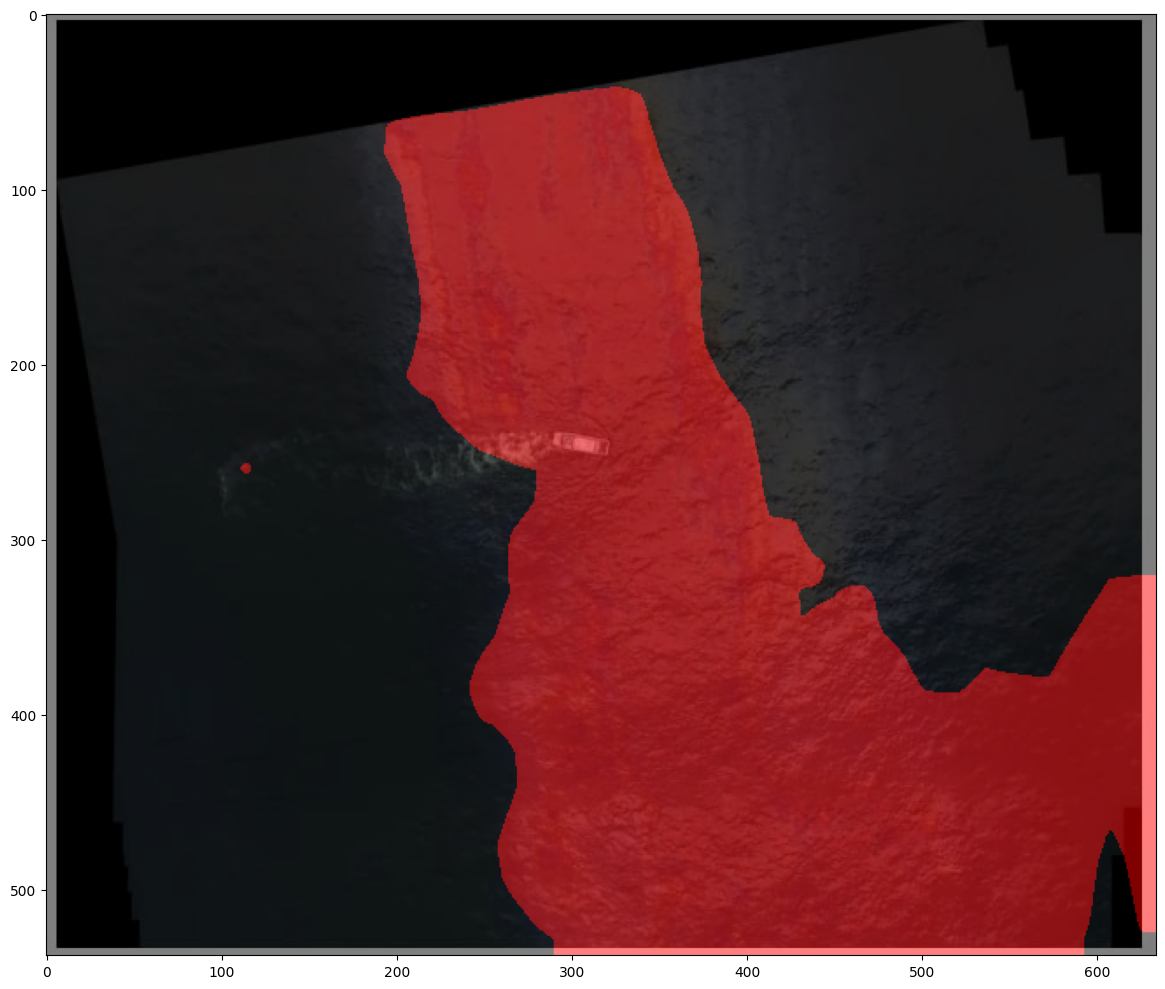

In [39]:
img = mmcv.imread('test.jpeg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)

In [ ]:
task.completed()

In [ ]:
task.close()

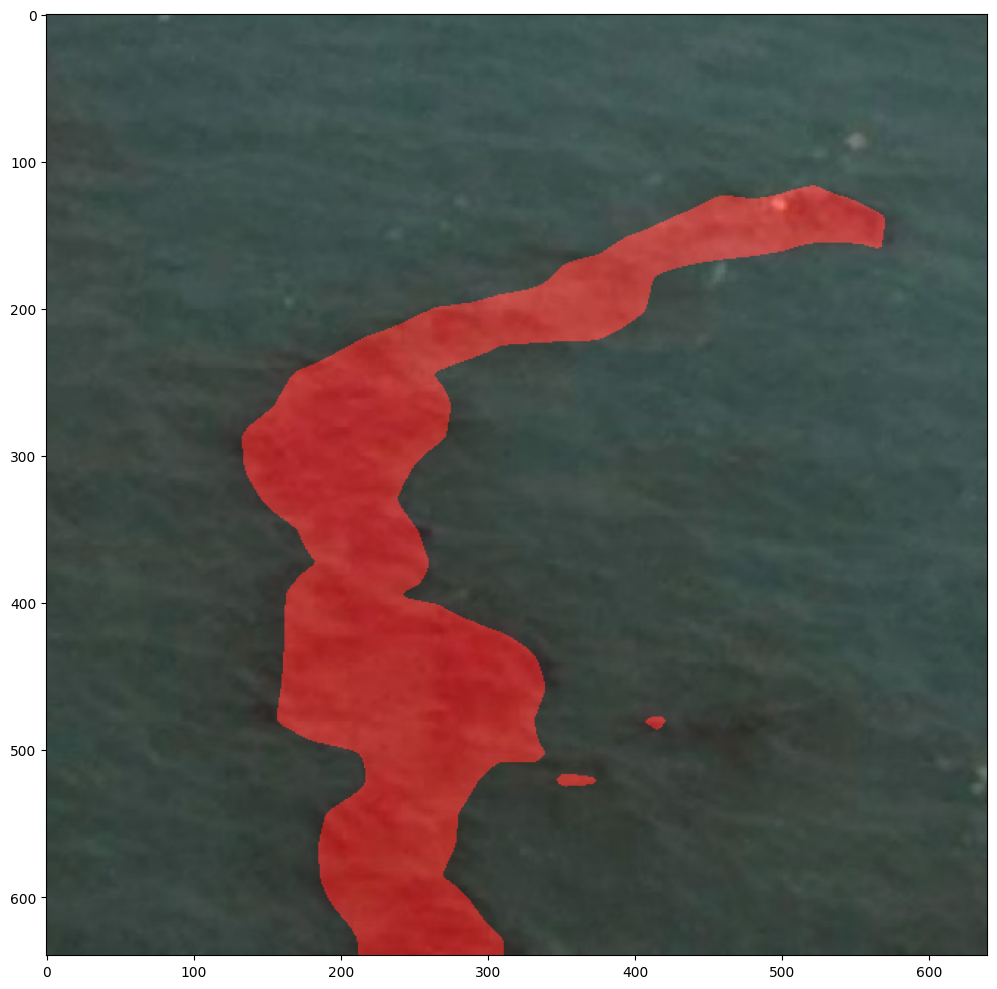

In [42]:
img = mmcv.imread('./dataset/test/images/82_jpg.rf.24ce608bc3f3a0d8a8cd9c480fd0107f.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)

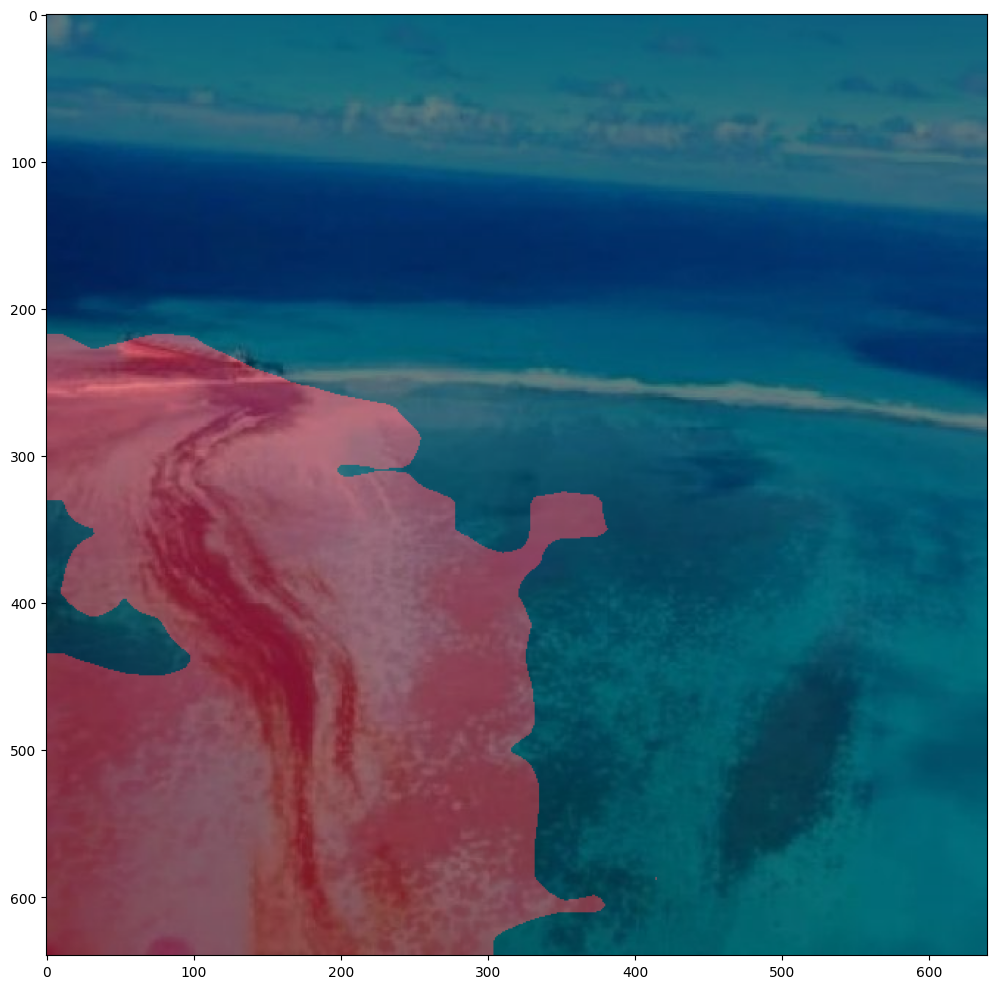

In [43]:
img = mmcv.imread('./dataset/test/images/2_jpg.rf.2b08ac4536828a76bd15debc2b513e4e.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
show_result_pyplot(model, img, result, palette)